In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import glob
import pandas as pd 
import seaborn as sns

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Lambda, Dropout

import tensorflow as tf

Using TensorFlow backend.


In [2]:
image_folders = ["map2/","map3/", "map2_turn/"]

In [3]:
# load all image name of all image folders
image_names = []
folder_names = []
steers = []
speeds = []

image_data = []
target = None
image_paths = []

for folder_name in image_folders:
    image_paths += glob.glob("/home/namntse05438/Cuoc_Dua_So/Ros_python/"+folder_name+"*.jpg")
    
print("Total read images: ", len(image_paths))

for path in image_paths:
    tmp = path.split("/")
    image_name = tmp[-1]
    folder_name = tmp[-2]
    # delete ".jpg" extension
    image_name = image_name[:-4]
    # print(image_name)
    image_names.append(image_name)
    folder_names.append(folder_name)
    
    tmp = image_name.split("_")
    speed = tmp[1]
    steer = tmp[2]
    steers.append(steer)
    speeds.append(speed)
    # print(speed)
    # print(steer)
    
# make dataframe containing info of all images (name, speed, steer)
data = pd.DataFrame({"name":image_names,"path":image_paths, "speed":speeds, "steer":steers, "folder_name":folder_names})
data.head()

Total read images:  8165


,name,path,speed,steer,folder_name
0,1546014233.95_50_0.00165315992043,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,0.00165315992043,map2
1,1546014103.21_50_0.0150572402819,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,0.0150572402819,map2
2,1546014058.02_50_0.112754050913,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,0.112754050913,map2
3,1546014231.18_50_-2.02498203262e-10,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,-2.02498203262e-10,map2
4,1546014078.86_50_0.0200879615841,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,0.0200879615841,map2


In [4]:
data['steer'] = data['steer'].astype(float)

/home/namntse05438/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


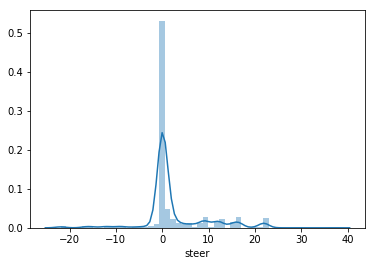

In [5]:
# data analysis
sns.distplot(data['steer'])

In [6]:
# split data into mid and left_right by a threshold
# mid is usually larger because when driving on the road, most of the time we go straight
thresh = 1
data['is_left_right'] = (data['steer']>=thresh) | (data['steer']<=-thresh)
data.head()

,name,path,speed,steer,folder_name,is_left_right
0,1546014233.95_50_0.00165315992043,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,1.653160e-03,map2,False
1,1546014103.21_50_0.0150572402819,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,1.505724e-02,map2,False
2,1546014058.02_50_0.112754050913,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,1.127541e-01,map2,False
3,1546014231.18_50_-2.02498203262e-10,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,-2.024982e-10,map2,False
4,1546014078.86_50_0.0200879615841,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,2.008796e-02,map2,False


In [7]:
# shuffle dataframe
data = data.sample(frac=1).reset_index()
data.head()

,index,name,path,speed,steer,folder_name,is_left_right
0,3736,1546014275.22_50_9.25713353711,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,9.257134e+00,map2,True
1,4219,1546014147.34_50_11.2500000036,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,1.125000e+01,map2,True
2,736,1546014180.95_50_-2.02955763294e-12,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,-2.029558e-12,map2,False
3,5316,1546014176.57_50_4.75738190189,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,4.757382e+00,map2,True
4,840,1546014225.92_50_4.78813363252e-05,/home/namntse05438/Cuoc_Dua_So/Ros_python/map2...,50,4.788134e-05,map2,False


In [8]:
print("Left right data: ", sum(data['is_left_right'] == True))
print("Mid data: ", sum(data['is_left_right'] == False))

Left right data:  2777
Mid data:  5388


In [9]:
def flip_image(img):
    flipped = cv2.flip(img, 1)
    return flipped

In [10]:
# big batch size
big_batch_size = 1024

def fetch_big_batch(b_index):
    image_data = []
    target = []
    start = b_index*big_batch_size
    end = start + big_batch_size
    df = data.iloc[start:end]
    
    for index, row in df.iterrows():
        img = cv2.imread(row['path'])
        image_data.append(img)
        target.append(row['steer'])
        if(row['is_left_right']):
            flip_img = flip_image(img)
            image_data.append(flip_img)
            target.append(-row['steer'])
            
    image_data = np.array(image_data)
    target = np.array(target).reshape(-1,1)

#     print("Shape of image_data: ",image_data.shape)
#     print("Shape of target: ", target.shape)
    return image_data, target

# fetch_big_batch(0)

In [11]:
# define model
#model.reset_states()
model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=(240, 320,3)))
model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(1))
model.summary()

model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer())
model.load_weights('my_model_01_04_11_01.h5')

/home/namntse05438/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="elu", strides=(2, 2))`
  """
/home/namntse05438/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  
/home/namntse05438/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  import sys
/home/namntse05438/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/home/namntse05438/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 240, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 118, 158, 24)      1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 37, 48)        43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 35, 64)        27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 23, 33, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 33, 64)        0         
__________

In [12]:
b_index = 0
n_big_batches = int(len(data) // big_batch_size)
n_big_epochs = 10

for epoch in range(n_big_epochs):
    print("---------------- Epoch %d ----------------"%(epoch))
    for b_index in range(n_big_batches+1):
        image_data, target = fetch_big_batch(b_index)
        print(image_data.shape)
        model.fit(image_data, target, epochs=2, batch_size=200, verbose=1)

---------------- Epoch 0 ----------------
(1376, 240, 320, 3)
Epoch 1/2
1376/1376 [==============================] - 11s 8ms/step - loss: 5.8414
Epoch 2/2
1376/1376 [==============================] - 4s 3ms/step - loss: 4.1022
(1383, 240, 320, 3)
Epoch 1/2
1383/1383 [==============================] - 6s 4ms/step - loss: 6.9021
Epoch 2/2
1383/1383 [==============================] - 4s 3ms/step - loss: 3.5849
(1378, 240, 320, 3)
Epoch 1/2
1378/1378 [==============================] - 6s 4ms/step - loss: 5.8309
Epoch 2/2
1378/1378 [==============================] - 4s 3ms/step - loss: 2.7421
(1352, 240, 320, 3)
Epoch 1/2
1352/1352 [==============================] - 5s 4ms/step - loss: 5.6744
Epoch 2/2
1352/1352 [==============================] - 4s 3ms/step - loss: 2.4593
(1366, 240, 320, 3)
Epoch 1/2
1366/1366 [==============================] - 5s 4ms/step - loss: 5.3429
Epoch 2/2
1366/1366 [==============================] - 4s 3ms/step - loss: 2.3838
(1372, 240, 320, 3)
Epoch 1/2
1372/13

1352/1352 [==============================] - 4s 3ms/step - loss: 1.9156
Epoch 2/2
1352/1352 [==============================] - 4s 3ms/step - loss: 0.9699
(1366, 240, 320, 3)
Epoch 1/2
1366/1366 [==============================] - 4s 3ms/step - loss: 1.5681
Epoch 2/2
1366/1366 [==============================] - 4s 3ms/step - loss: 0.8244
(1372, 240, 320, 3)
Epoch 1/2
1372/1372 [==============================] - 4s 3ms/step - loss: 1.7331
Epoch 2/2
1372/1372 [==============================] - 4s 3ms/step - loss: 1.0111
(1381, 240, 320, 3)
Epoch 1/2
1381/1381 [==============================] - 4s 3ms/step - loss: 1.4824
Epoch 2/2
1381/1381 [==============================] - 4s 3ms/step - loss: 0.9513
(1334, 240, 320, 3)
Epoch 1/2
1334/1334 [==============================] - 4s 3ms/step - loss: 1.6669
Epoch 2/2
1334/1334 [==============================] - 4s 3ms/step - loss: 0.8858
---------------- Epoch 6 ----------------
(1376, 240, 320, 3)
Epoch 1/2
1376/1376 [===========================

In [13]:
model.save_weights("my_model_01_04_14_05.h5")